In [36]:
import numpy as np
import pandas as pd
import pickle
import re  
import string
from collections import Counter
import nltk 
# nltk.download('stopwords')  
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
dk = pd.read_pickle('../data/dk.pkl')
fd = pd.read_pickle('../data/fd.pkl')

In [4]:
print(dk.info())
print(fd.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5257 entries, 0 to 8930
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created         5257 non-null   object
 1   text            5257 non-null   object
 2   username        5257 non-null   object
 3   location        3746 non-null   object
 4   follower count  5257 non-null   int64 
 5   friend count    5257 non-null   int64 
 6   retweet         5257 non-null   int64 
 7   source          5253 non-null   object
dtypes: int64(3), object(5)
memory usage: 369.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4319 entries, 0 to 5747
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created         4319 non-null   object
 1   text            4319 non-null   object
 2   username        4319 non-null   object
 3   location        3310 non-null   object
 4   follower count  4319 n

# Cleaning the Text

In [19]:
#example tweet before cleaning
dk.text[0]

'b"WHO IS THE # 1\\xe2\\x83\\xa3 SERVICE IN COLLEGE BASKETBALL?\\n\\nIT\'S US AND IT\'S VERIFIED! MEMBERS ALREADY UP OVER $9K AND IT\'S VER\\xe2\\x80\\xa6 https://t.co/Hv8hILrib8"'

In [15]:
def clean_tweets(raw_text):
    stopwords_set = set(stopwords.words('english'))
    #Remove punctuations and stopwords
    cleaned = " ".join([i for i in re.sub(r'[^\w\s]', " ", raw_text).lower().split() if i not in stopwords_set])
    #Remove prefixed 'b'
    cleaned = re.sub(r'^b\s+', "", cleaned)
    #Remove retweet 'rt'
    cleaned = re.sub(r'^rt\s+', "", cleaned)
    # Remove single characters from the start
    cleaned = re.sub(r'\^[a-zA-Z]\s+', ' ', cleaned) 
    # Remove single characters
    cleaned = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleaned)
    # Remove words with '_'  
    cleaned = re.sub('\w*\_\w*', ' ', cleaned)
    #Remove URLs
    cleaned = re.sub(r'http\S+', "", cleaned) 
    # Remove words with containing numbers
    cleaned = re.sub('\w*\d\w*', '', cleaned)
    # Substituting multiple spaces with single space
    cleaned= re.sub(r'\s+', ' ', cleaned, flags=re.I)
    return cleaned

In [21]:
dk_clean = pd.DataFrame(dk.text.apply(clean_tweets))
fd_clean = pd.DataFrame(fd.text.apply(clean_tweets))

In [22]:
#example tweet after cleaning
dk_clean.text[0]

' service college basketball nit us verified members already ver co '

In [780]:
# Another Option to clean and vectorize

# dk_corpus = "".join([str(i) for i in dk['text']])
# cleaned = preprocess(dk_corpus)

# from nltk.tokenize import TweetTokenizer
# tt = TweetTokenizer()
# tokens = tt.tokenize(cleaned)

# stemmer = SnowballStemmer('english')
# stems = [stemmer.stem(token) for token in tokens]

# vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
#             strip_accents='unicode', analyzer='word',
#             ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
#             stop_words = 'english')
# X = tfv.fit_transform(stems)


In [23]:
dk_clean.to_pickle("../data/dk_clean.pkl")
fd_clean.to_pickle("../data/fd_clean.pkl")

# Customize stopwords for vectorizer

In [39]:
from sklearn.feature_extraction import text

dk_cleaned_tweets = dk_clean.text
dk_all_words = "".join(dk_cleaned_tweets).split()
print(f'Draktkings \n {Counter(dk_all_words).most_common(25)}')

fd_cleaned_tweets = fd_clean.text
fd_all_words = "".join(fd_cleaned_tweets).split()
print(f'FanDuel \n {Counter(fd_all_words).most_common(25)}')

Draktkings 
 [('co', 4001), ('nfl', 1987), ('dfs', 1972), ('draftkings', 1884), ('fanduel', 1302), ('n', 1265), ('vs', 734), ('week', 699), ('guaranteedpick', 614), ('win', 591), ('dailysportpickz', 583), ('free', 552), ('thanksgiving', 531), ('rts', 522), ('fantasyfootball', 514), ('showdown', 500), ('amp', 454), ('giveaway', 433), ('tonight', 414), ('tweet', 408), ('give', 394), ('xef', 356), ('game', 345), ('picks', 336), ('expertpicks', 318)]
FanDuel 
 [('co', 3274), ('n', 1654), ('fanduel', 1609), ('dfs', 1579), ('nfl', 1570), ('draftkings', 1018), ('vs', 548), ('jerseykidpicks', 547), ('thanksgiving', 542), ('week', 515), ('fantasyfootball', 502), ('guaranteedpick', 498), ('win', 409), ('dailysportpickz', 403), ('free', 387), ('amp', 374), ('giveaway', 365), ('showdown', 336), ('rts', 332), ('xef', 309), ('expertpicks', 272), ('give', 266), ('tweet', 261), ('today', 253), ('tonight', 243)]


In [40]:
#update stopwords
dk_add_stop_words = [word for word, count in Counter(dk_all_words).most_common() if count > 699] #chose to cut off based on most_common
fd_add_stop_words = [word for word, count in Counter(fd_all_words).most_common() if count > 547] #chose to cut off based on most_common

remove = ['xef', 'rts', 'snf', 'mnf', 'dk', 'dfs', 'cbb', 'gt', 'nthe', 'get', 'nwe', 'nmust', 'xbd', 'give', 'xbd']

for word in remove:
    dk_add_stop_words.append(word)
    fd_add_stop_words.append(word)
    
dk_stop_words = text.ENGLISH_STOP_WORDS.union(dk_add_stop_words)
fd_stop_words = text.ENGLISH_STOP_WORDS.union(fd_add_stop_words)

# TFIDF Vectorizer and Word Clouds

In [41]:
dk_vectorizer = TfidfVectorizer(min_df=3,  max_features=1500, max_df = .7,
            strip_accents='unicode', analyzer='word', ngram_range = (1,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = dk_stop_words)
dk_X = dk_vectorizer.fit_transform(dk_clean.text)
dk_words = dk_vectorizer.get_feature_names()

#Document Term Matrix
dk_DTmatrix = pd.DataFrame(dk_X.toarray(), columns=dk_words)
dk_DTmatrix.to_pickle("../data/dk_DTmatrix.pkl")

In [43]:
fd_vectorizer = TfidfVectorizer(min_df=3,  max_features=1500, max_df = .7,
            strip_accents='unicode', analyzer='word', ngram_range = (1,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = fd_stop_words)

fd_X = fd_vectorizer.fit_transform(fd_clean.text)
fd_words = fd_vectorizer.get_feature_names()

#Document Term Matrix
fd_DTmatrix = pd.DataFrame(fd_X.toarray(), columns=fd_words)
fd_DTmatrix.to_pickle("../data/fd_DTmatrix.pkl")

<function matplotlib.pyplot.show(*args, **kw)>

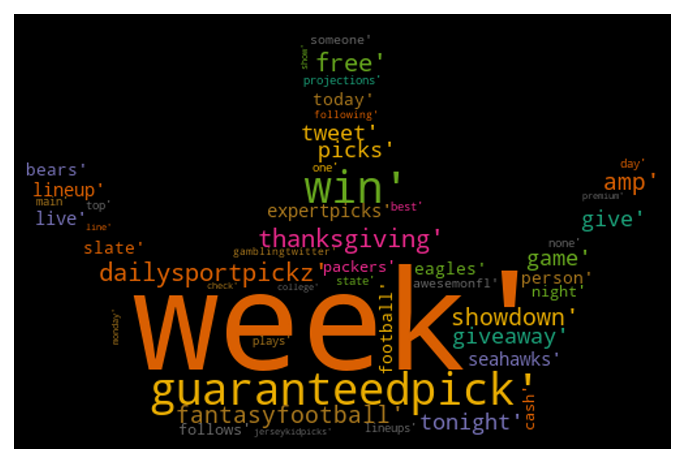

In [44]:
from PIL import Image

dk_wc_words = [word for word in all_words if word not in add_stop_words]
dk_wc_words_counts = Counter(dk_wc_words).most_common(50)

dk_mask = np.array(Image.open('../img/crown.jpg'))

wc = WordCloud(background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42, mask=dk_mask).generate("".join(str(dk_wc_words_counts)))

plt.axis('off')
plt.imshow(wc, interpolation="spline16")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

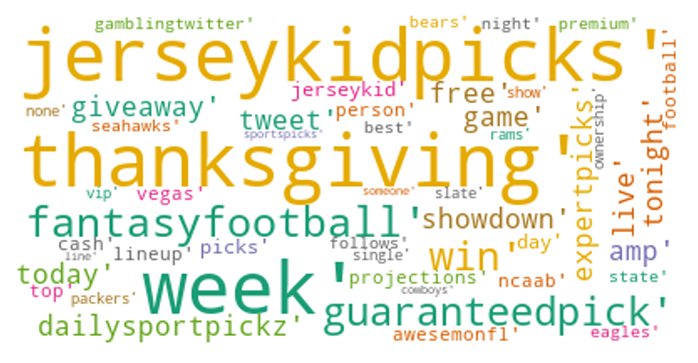

In [46]:
fd_wc_words = [word for word in fd_all_words if word not in fd_add_stop_words]
fd_wc_words_counts = Counter(fd_wc_words).most_common(50)

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42).generate("".join(str(fd_wc_words_counts)))

plt.axis('off')
plt.imshow(wc, interpolation="spline16")
plt.show

In [48]:
pickle.dump(dk_vectorizer, open("../data/dk_vectorizer.pkl", "wb"))
pickle.dump(fd_vectorizer, open("../data/fd_vectorizer.pkl", "wb"))

### Top Word Comparison

In [61]:
dk_top_words = []
for i in range(len(dk_wc_words_counts)):
    dk_top_words.append(dk_wc_words_counts[i][0])

fd_top_words = []
for i in range(len(fd_wc_words_counts)):
    fd_top_words.append(fd_wc_words_counts[i][0])

top_words_df = list(zip(dk_top_words, fd_top_words))
top_words_df = pd.DataFrame(top_words_df, columns = ['DraftKings Top Words', 'FanDuel Top Words'])
top_words_df.head(10)

,DraftKings Top Words,FanDuel Top Words
0,week,jerseykidpicks
1,guaranteedpick,thanksgiving
2,win,week
3,dailysportpickz,fantasyfootball
4,free,guaranteedpick
5,thanksgiving,win
6,fantasyfootball,dailysportpickz
7,showdown,free
8,amp,amp
9,giveaway,giveaway


In [62]:
dk_difference = list(set(dk_top_words) - set(fd_top_words))
fd_difference = list(set(fd_top_words) - set(dk_top_words))
difference_df = list(zip(dk_difference, fd_difference))
difference_words_df = pd.DataFrame(difference_df, columns = ['Only in DraftKings', 'Only in FanDuel'])
difference_words_df #there are only 8 words that are different

,Only in DraftKings,Only in FanDuel
0,following,single
1,give,vip
2,one,sportspicks
3,lineups,cowboys
4,monday,jerseykid
5,college,ownership
6,plays,vegas
7,check,ncaab
8,main,rams


# NMF Topic Modeling

In [97]:
dk_vocab = np.array(dk_vectorizer.get_feature_names())
fd_vocab = np.array(fd_vectorizer.get_feature_names())

In [98]:
from sklearn.decomposition import NMF

dk_nmf = NMF(n_components=3, max_iter=2000, alpha=0.0)
dk_W = dk_nmf.fit_transform(dk_X)
dk_H = dk_nmf.components_
print('dk_reconstruction error:', dk_nmf.reconstruction_err_)

fd_nmf = NMF(n_components=3, max_iter=2000, alpha=0.0)
fd_W = fd_nmf.fit_transform(fd_X)
fd_H = fd_nmf.components_
print('fd_reconstruction error:', fd_nmf.reconstruction_err_)

dk_reconstruction error: 69.8279589446861
fd_reconstruction error: 63.63251563263285


In [99]:
def label_topics(H, vocabulary):
    labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:30]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_five]))
        label = input('\n' + 'topic guess:')
        labels.append(label)
        print()
    return labels

In [101]:
dk_topic_labels = label_topics(dk_H, dk_vocab)

topic 0
--> win tonight tweet follows follows tonight tweet win dailysportpickz packers bears packers win tonight bears person tweet bears person dailysportpickz packers person tonight seahawks seahawks tweet eagles win ven follows ven dailysportpickz eagles seahawks eagles bears win tonight packers packers tweet dailysportpickz bears venmo follows venmo dailysportpickz giveaway



topic guess: Upcoming Game



topic 1
--> free giveaway giveaway person person win following free following person dailysportpickz win lineup lineup free premium seahawks eagles win premium premium lineup eagles giveaway showdown dailysportpickz seahawks following ente ente seahawks line eagles line free enter win line following enter fantasyfootball packers bears bears giveaway



topic guess: Promotions



topic 2
--> guaranteedpick guaranteedpick realbobbasports realbobbasports expertpicks marchmadness guaranteedpick servicesbam servicesbam state guaranteedpick expertpicks expertpicks sportspicks sportspicks realbobbasports expertpicks servicesbam expertpicks state guaranteedpick realbobbasports marchmadness texas servicesbam marchmadness carolina sportspicks mlb mlb marchmadness expertpicks guaranteedpick marchmadness city guaranteedpick thewackyreport thewackyreport st north guaranteedpick tampasports tampasports guaranteedpick thewagermakers



topic guess: Picks and Bets


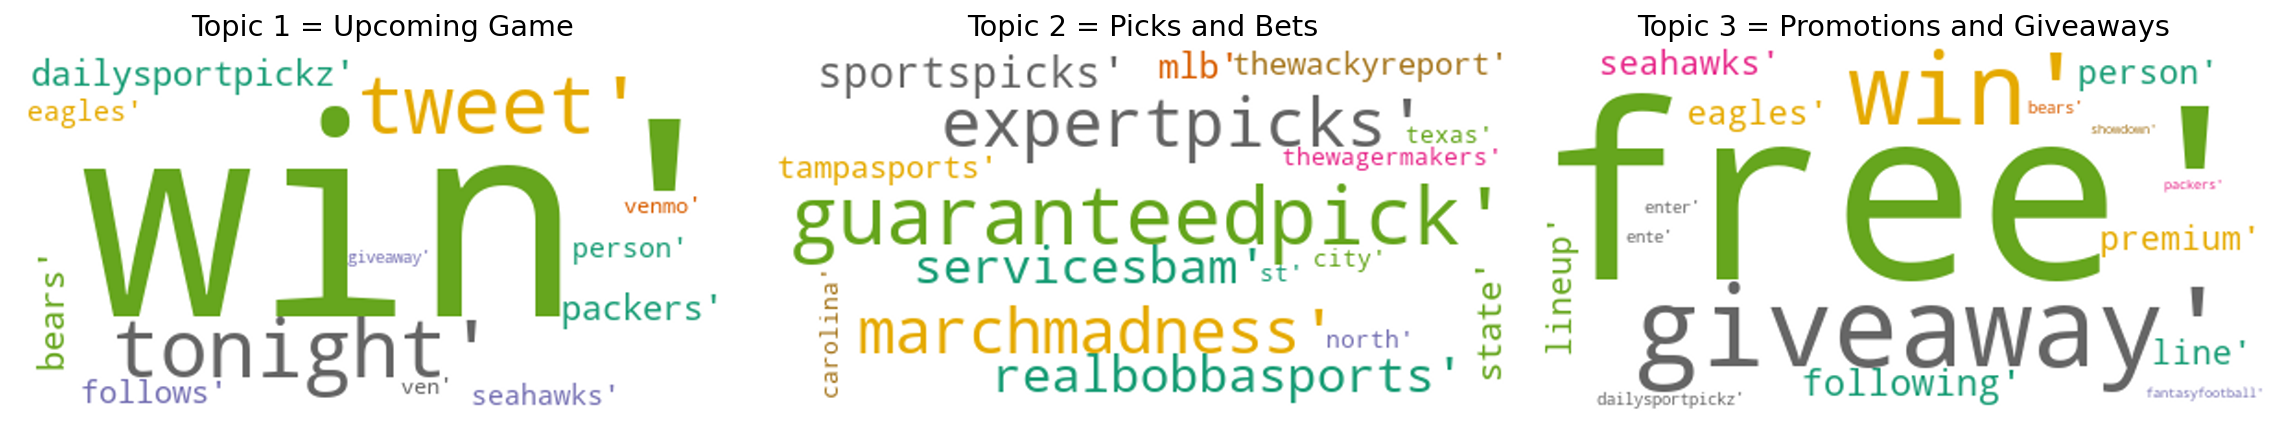

In [102]:
game = 'win tonight tweet follows follows tonight tweet win dailysportpickz packers bears packers win \
        tonight bears person tweet bears person dailysportpickz packers person tonight seahawks seahawks \
        tweet eagles win ven follows ven dailysportpickz eagles seahawks eagles bears win tonight packers \
        packers tweet dailysportpickz bears venmo follows venmo dailysportpickz giveaway'.split() 

bets = 'guaranteedpick guaranteedpick realbobbasports realbobbasports expertpicks marchmadness guaranteedpick \
        servicesbam servicesbam state guaranteedpick expertpicks expertpicks sportspicks sportspicks realbobbasports \
        expertpicks servicesbam expertpicks state guaranteedpick realbobbasports marchmadness texas servicesbam \
        marchmadness carolina sportspicks mlb mlb marchmadness expertpicks guaranteedpick marchmadness city guaranteedpick \
        thewackyreport thewackyreport st north guaranteedpick tampasports tampasports guaranteedpick thewagermakers'.split()

promo = 'free giveaway giveaway person person win following free following person dailysportpickz win lineup \
    lineup free premium seahawks eagles win premium premium lineup eagles giveaway showdown dailysportpickz \
    seahawks following ente ente seahawks line eagles line free enter win line following enter fantasyfootball \
    packers bears bears giveaway'.split()

fig = plt.figure(figsize = (16,8))

ax1 = fig.add_subplot(131)
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=30, mask=None).generate("".join(str(game)))
ax1.set_title('Topic 1 = Upcoming Game')
ax1.axis('off')
ax1.imshow(wc, interpolation="spline16")

ax2 = fig.add_subplot(132)
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=30, mask=None).generate("".join(str(bets)))
ax2.set_title('Topic 2 = Picks and Bets')
ax2.axis('off')
ax2.imshow(wc, interpolation="spline16")

ax3 = fig.add_subplot(133)
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=30, mask=None).generate("".join(str(promo)))
ax3.set_title('Topic 3 = Promotions and Giveaways')
ax3.axis('off')
ax3.imshow(wc, interpolation="spline16")

plt.tight_layout()

In [111]:
fd_topic_labels = label_topics(fd_H, fd_vocab)

topic 0
--> dailysportpickz win tweet follows tweet follows tonight win tonight person giveaway packers bears dailysportpickz packers free giveaway person person win person tweet bears person tonight bears packers win following free following eagles seahawks lineup showdown dailysportpickz giveaway lineup free tonight seahawks eagles win seahawks tweet



topic guess: Promotions



topic 1
--> fantasyfootball projections ownership game ownership projections projections fantasyfootball single single game showdown single showdown thanksgiving rankings ownership rankings rankings fantasyfootball thanksgiving fantasyfootball plays game projections game plays game ranks ranks week plays fantasyfootball amp check projections thanksgiving larvstb fantasyfootball larvstb stacks picks projections msbmegfary



topic guess: Upcoming Game



topic 2
--> guaranteedpick expertpicks realbobbasports guaranteedpick realbobbasports state marchmadness servicesbam guaranteedpick servicesbam guaranteedpick expertpicks expertpicks sportspicks sportspicks realbobbasports expertpicks state guaranteedpick servicesbam expertpicks texas realbobbasports marchmadness mlb sportspicks mlb servicesbam marchmadness thewagermakers guaranteedpick thewagermakers carolina city mlb cfb st cfb rams lar lar north marchmadness expertpicks



topic guess: Picks and Bets


# Draktkings Topic Deepdive

In [103]:
dk_W.shape

(5257, 3)

In [104]:
dk_topic = pd.DataFrame(dk_W, columns = dk_topic_labels)
dk_topic['topic_guess'] = dk_topic.idxmax(axis=1)

In [763]:
dk_topic.head(50)

,Upcoming Game,Promotions,Picks and Bets,topic_guess
0,0.000000,0.006167,0.004777,Promotions
1,0.004741,0.041442,0.002216,Promotions
2,0.000000,0.006343,0.002170,Promotions
3,0.000000,0.002479,0.001273,Promotions
4,0.000000,0.003638,0.000240,Promotions
5,0.000000,0.000000,0.115897,Picks and Bets
6,0.000000,0.006718,0.002298,Promotions
7,0.000000,0.006718,0.002298,Promotions
8,0.000000,0.007682,0.002312,Promotions
9,0.000000,0.006718,0.002298,Promotions


In [105]:
dk_counter = dict(Counter(dk_topic.topic_guess))
for k, v, in dk_counter.items():
    dk_counter[k] = str(round((v/5257)*100))+'%'
dk_counter

{'Promotions': '73%', 'Picks and Bets': '18%', 'Upcoming Game': '8%'}

In [108]:
# To view example tweets in each topic
pd.set_option("display.max_colwidth", None)

game_indexes = dk_topic[dk_topic.topic_guess == "Upcoming Game"].index
game = dk.loc[dk.index.isin(game_indexes)]

promotions_indexes = dk_topic[dk_topic.topic_guess == "Promotions"].index
promotions = dk.loc[dk.index.isin(promotions_indexes)]

picks_indexes = dk_topic[dk_topic.topic_guess == "Picks and Bets"].index
picks = dk.loc[dk.index.isin(picks_indexes)]


# FanDuel Topic Deepdive

In [112]:
fd_W.shape

(4319, 3)

In [113]:
fd_topic = pd.DataFrame(fd_W, columns = fd_topic_labels)
fd_topic['topic_guess'] = fd_topic.idxmax(axis=1)

In [114]:
fd_counter = dict(Counter(fd_topic.topic_guess))
for k, v, in fd_counter.items():
    fd_counter[k] = str(round((v/4321)*100))+'%'
    
fd_counter

{'Promotions': '26%', 'Upcoming Game': '49%', 'Picks and Bets': '25%'}

In [116]:
pd.set_option("display.max_colwidth", None)

fd_game_indexes = fd_topic[fd_topic.topic_guess == "Upcoming Game"].index
fd_game = fd.loc[fd.index.isin(fd_game_indexes)]

fd_promo_indexes = fd_topic[fd_topic.topic_guess == "Promotions"].index
fd_promo = fd.loc[fd.index.isin(fd_promo_indexes)]

fd_picks_indexes = fd_topic[fd_topic.topic_guess == "Picks and Bets"].index
fd_picks = fd.loc[fd.index.isin(fd_picks_indexes)]


/Users/LMC/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


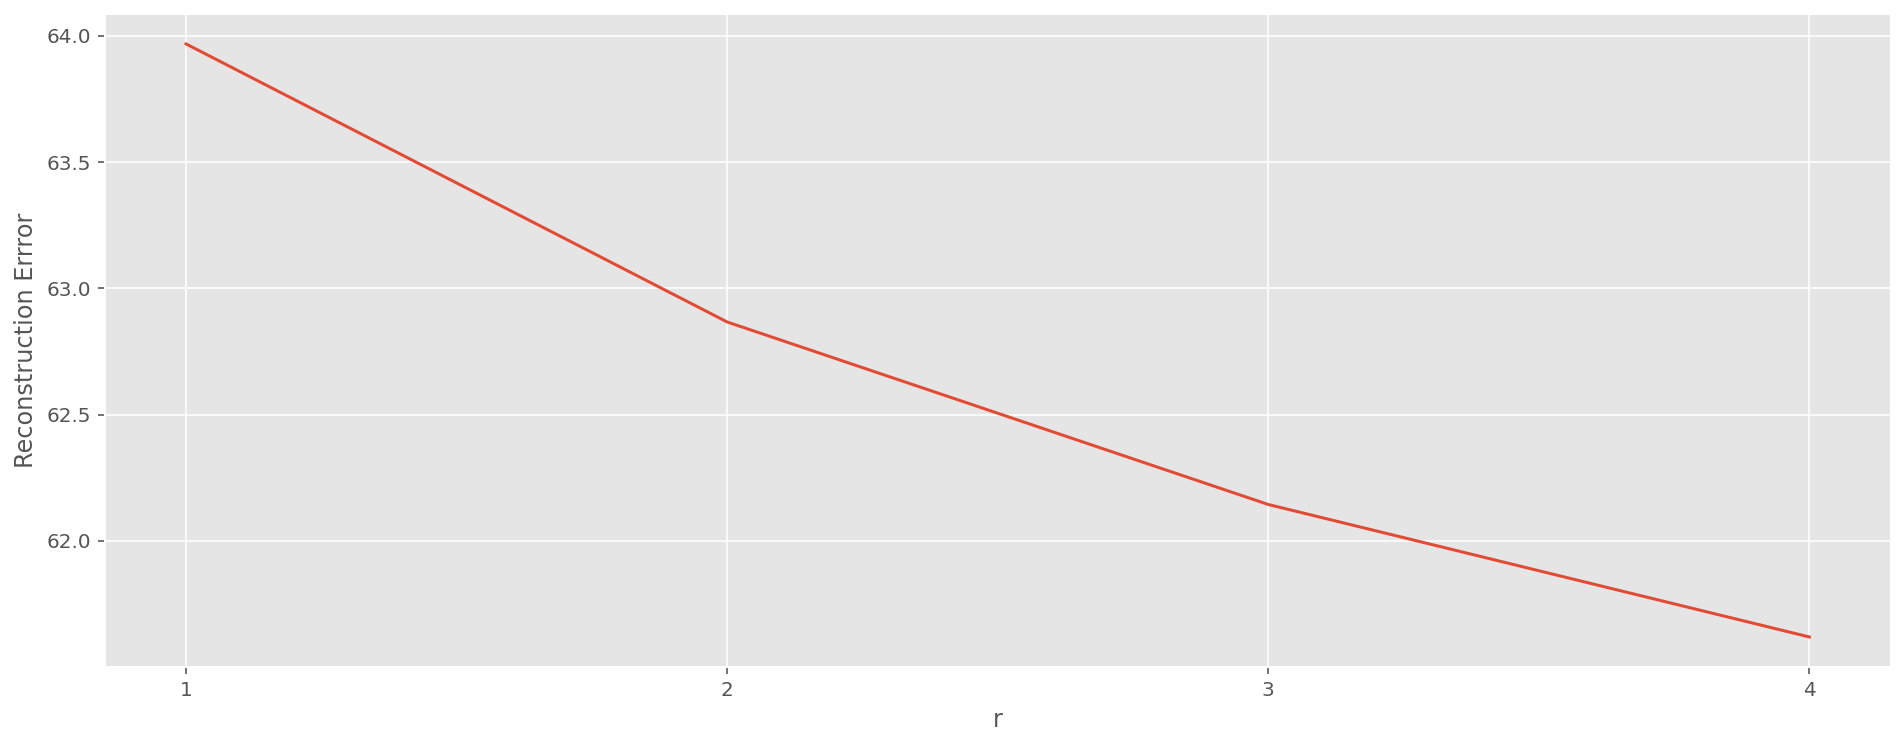

In [563]:
def fit_nmf(r):
    nmf = NMF(n_components=r, max_iter=50, alpha=0.0)
    nmf.fit(X)
    W = nmf.transform(dk_X)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,5)]
plt.plot(range(1,5), error)
plt.xticks(range(1, 5))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')
plt.show()